# Transferring Image Styles

This notebook provides you with a complete code example that loads the content image, the style image, and the VGG16 pre-trained neural network, and uses them to transfer the style to the image.

## Loading the Content and Style Images

Load a crop of the content image ...

In [1]:
from PIL import Image

content = (
    Image.open("neuraltissue_with_colorlabels.png")
    .convert("RGB")
    .crop((100, 170, 100 + 256, 170 + 256)) 
)

... plot it ...

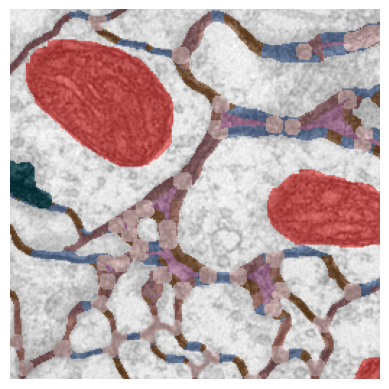

In [2]:
import matplotlib.pyplot as plt

plt.imshow(content)
plt.axis("off")
plt.show()

... load the style image ...

In [3]:
style = Image.open("lizard.png").convert("RGB").resize((256, 256))

... and plot it.

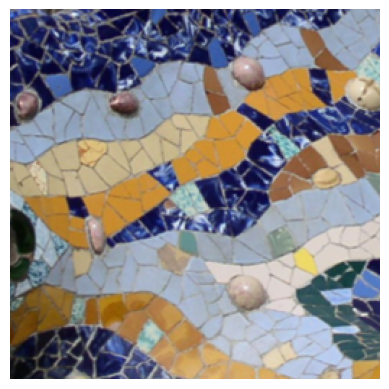

In [4]:
plt.imshow(style)
plt.axis("off")
plt.show()

## Loading a Pre-Trained Neural Network

In [5]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import numpy as np
import torch

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

low = torch.tensor((- mean / std).reshape(1, -1, 1, 1))
high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

## Implementing Style Transfer

Implement a function to calculate the Gram matrix between all the activations of a specific layer ...

In [7]:
from torch import bmm

def gram(tensor):
    """Gram matrix."""
    batch_size, num_channels, height, width = tensor.size()
    features = tensor.view(batch_size, num_channels, height * width)
    gram_matrix = bmm(features, features.transpose(1, 2)) / (height * width)
    return gram_matrix

... define functions to to convert an image to a tensor, and vice versa ...

In [8]:
import torchvision.transforms as tt

def image_to_tensor(im, mean, std):
    """Convert image to tensor."""
    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)]) 
    return normalize(im).unsqueeze(0).requires_grad_(True)

def tensor_to_image(image, mean, std):
    """Convert tensor to image."""
    denormalize = tt.Normalize(mean=- mean / std, std=1 / std)
    im_array = denormalize(image.data.clone().detach().squeeze()).numpy() 
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255)
    im_array = im_array.astype(np.uint8)
    return Image.fromarray(im_array, "RGB")

... define a context manager class ...

In [9]:
class Fwd_Hooks():
    """Forward hook."""
    
    def __init__(self, layers):
        """Initialize forward hooks."""
        self.hooks = []
        self.activations_list = []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))
    
    def hook_func(self, layer, input, output):
        """Save activations."""
        self.activations_list.append(output)

    def __enter__(self, *args):
        """Enter context and register hooks."""
        return self

    def __exit__(self, *args):
        """Exit context management and remove hooks."""
        for hook in self.hooks:
            hook.remove()

... and define a function to implement style transfer.

In [10]:
def style_transfer(image, content, style, content_layers, style_layers,
                   lr=1, iter_num=100, beta=1e3):
    """Perform style transfer."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    image_tensor = image_to_tensor(image, mean, std)
    
    with Fwd_Hooks(content_layers) as fh:
        _ = model(image_to_tensor(content, mean, std))
    content_activations = [activations.detach()
                           for activations in fh.activations_list]
    
    with Fwd_Hooks(style_layers) as fh:
        _ = model(image_to_tensor(style, mean, std))
    gram_targets = [gram(activations.detach())
                    for activations in fh.activations_list]

    optimizer = torch.optim.LBFGS([image_tensor], lr=lr) 
    mse_loss = torch.nn.MSELoss(reduction="sum")

    def closure():
        """Closure function for the optimizer.""" 
        optimizer.zero_grad()
        
        with Fwd_Hooks(content_layers) as fh:
            _ = model(image_tensor)
        image_content_activations = fh.activations_list
        
        content_loss = 0
        for ia, ca in zip(image_content_activations, content_activations):
            n_f = ia.shape[1]
            content_loss += mse_loss(ia, ca) / n_f ** 2
        content_loss /= len(image_content_activations)
        
        with Fwd_Hooks(style_layers) as fh:
            _ = model(image_tensor)
        gram_image = [gram(activations) for activations in fh.activations_list]

        style_loss = 0
        for gi, gt in zip(gram_image, gram_targets):
            n_g = gi.shape[1]
            style_loss += mse_loss(gi, gt) / n_g ** 2
        style_loss /= len(gram_image) 
        
        print(f"content_loss={content_loss} style_loss={style_loss}")

        total_loss = content_loss + beta * style_loss
        total_loss.backward()        
        return total_loss
    
    for i in range(iter_num):
        print(f"iteration {i}")
        optimizer.step(closure)
        
        image = tensor_to_image(image_tensor, mean, std)

        if i <= 5 or i % 10 == 0 or i == iter_num - 1:
            plt.imshow(image)
            plt.title(f"Iteration {i}")
            plt.axis("off")
            plt.show()
    
    return image

## Transferring the Style of an Image to Another Image

Starting from a random image ...

iteration 0
content_loss=330.2001953125 style_loss=229.17495727539062
content_loss=330.19830322265625 style_loss=229.16000366210938
content_loss=305.2281799316406 style_loss=85.80683898925781
content_loss=290.3660888671875 style_loss=49.35456085205078
content_loss=275.3670959472656 style_loss=23.804996490478516
content_loss=266.9533996582031 style_loss=12.487568855285645
content_loss=265.2117919921875 style_loss=6.950543403625488
content_loss=276.8855895996094 style_loss=4.247895240783691
content_loss=312.2485656738281 style_loss=2.660998582839966
content_loss=350.41693115234375 style_loss=1.8286678791046143
content_loss=342.08428955078125 style_loss=1.3937050104141235
content_loss=361.2183837890625 style_loss=1.0950828790664673
content_loss=346.09613037109375 style_loss=0.93365079164505
content_loss=348.2518615722656 style_loss=0.7843493223190308
content_loss=348.37652587890625 style_loss=0.6680420637130737
content_loss=340.80224609375 style_loss=0.5786512494087219
content_loss=345.09

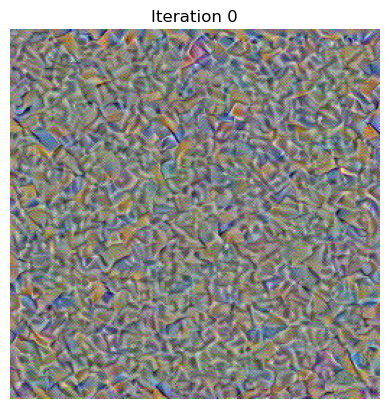

iteration 1
content_loss=328.1159362792969 style_loss=0.35563716292381287
content_loss=322.455322265625 style_loss=0.32339996099472046
content_loss=322.76605224609375 style_loss=0.28972527384757996
content_loss=309.8946838378906 style_loss=0.30090922117233276
content_loss=315.4549255371094 style_loss=0.26485294103622437
content_loss=315.2332763671875 style_loss=0.25183194875717163
content_loss=308.679931640625 style_loss=0.23989681899547577
content_loss=305.01043701171875 style_loss=0.22374308109283447
content_loss=303.38446044921875 style_loss=0.2077213078737259
content_loss=295.3465576171875 style_loss=0.20258641242980957
content_loss=296.4884338378906 style_loss=0.1865706741809845
content_loss=294.62542724609375 style_loss=0.1802404820919037
content_loss=283.99609375 style_loss=0.1833774298429489
content_loss=287.11199951171875 style_loss=0.16401314735412598
content_loss=285.188720703125 style_loss=0.16097678244113922
content_loss=275.468017578125 style_loss=0.16563363373279572
cont

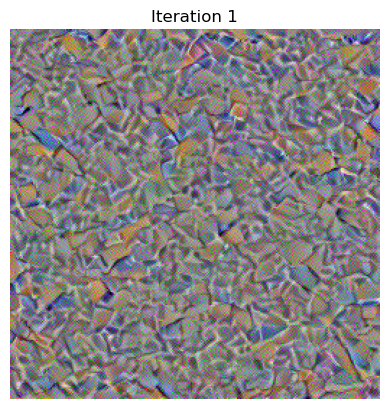

iteration 2
content_loss=268.71484375 style_loss=0.13307403028011322
content_loss=261.7266540527344 style_loss=0.13207009434700012
content_loss=262.44683837890625 style_loss=0.12292609363794327
content_loss=259.2579650878906 style_loss=0.12250570952892303
content_loss=255.50103759765625 style_loss=0.1205228716135025
content_loss=252.95639038085938 style_loss=0.11606891453266144
content_loss=250.73953247070312 style_loss=0.11196212470531464
content_loss=247.8032989501953 style_loss=0.11045406013727188
content_loss=246.12135314941406 style_loss=0.1064973846077919
content_loss=241.70925903320312 style_loss=0.10622632503509521
content_loss=239.13145446777344 style_loss=0.10294659435749054
content_loss=237.7897491455078 style_loss=0.09902450442314148
content_loss=231.96539306640625 style_loss=0.10283482074737549
content_loss=233.42515563964844 style_loss=0.0961463451385498
content_loss=232.11215209960938 style_loss=0.09496940672397614
content_loss=228.40306091308594 style_loss=0.09449575096

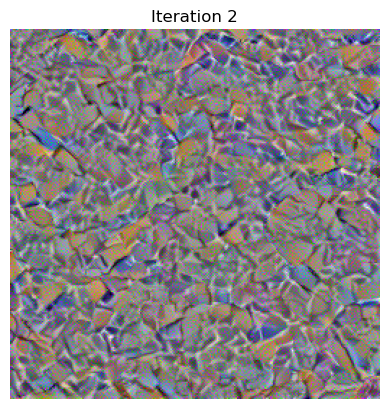

iteration 3
content_loss=220.41864013671875 style_loss=0.0858844742178917
content_loss=215.84130859375 style_loss=0.08692309260368347
content_loss=215.75360107421875 style_loss=0.08303976058959961
content_loss=213.71469116210938 style_loss=0.08291840553283691
content_loss=211.7410125732422 style_loss=0.08192090690135956
content_loss=209.9813690185547 style_loss=0.0803275853395462
content_loss=207.63479614257812 style_loss=0.0790390819311142
content_loss=205.42108154296875 style_loss=0.07784847915172577
content_loss=204.17324829101562 style_loss=0.07623539119958878
content_loss=202.95269775390625 style_loss=0.07543919235467911
content_loss=201.65350341796875 style_loss=0.07430693507194519
content_loss=198.28866577148438 style_loss=0.07521922886371613
content_loss=198.6963653564453 style_loss=0.0722203478217125
content_loss=197.14215087890625 style_loss=0.07182266563177109
content_loss=193.7501678466797 style_loss=0.07267586886882782
content_loss=194.22373962402344 style_loss=0.069629907

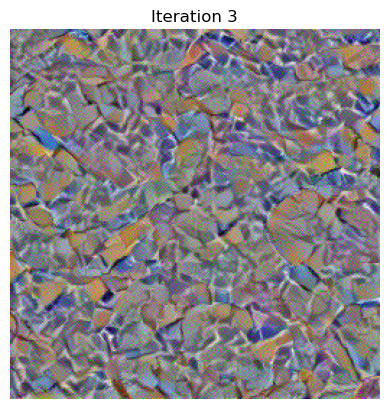

iteration 4
content_loss=187.01950073242188 style_loss=0.06730978190898895
content_loss=186.03118896484375 style_loss=0.06613703072071075
content_loss=184.9093475341797 style_loss=0.06491021066904068
content_loss=183.6431427001953 style_loss=0.0641767606139183
content_loss=181.37631225585938 style_loss=0.06427601724863052
content_loss=181.38528442382812 style_loss=0.06221423298120499
content_loss=179.0660400390625 style_loss=0.06244688481092453
content_loss=177.61532592773438 style_loss=0.06159336492419243
content_loss=175.9200439453125 style_loss=0.061582811176776886
content_loss=176.08682250976562 style_loss=0.059654951095581055
content_loss=174.43829345703125 style_loss=0.059995610266923904
content_loss=172.4420166015625 style_loss=0.0600762665271759
content_loss=171.7593994140625 style_loss=0.058640677481889725
content_loss=170.33172607421875 style_loss=0.058430444449186325
content_loss=169.83218383789062 style_loss=0.05721943825483322
content_loss=168.39425659179688 style_loss=0.0

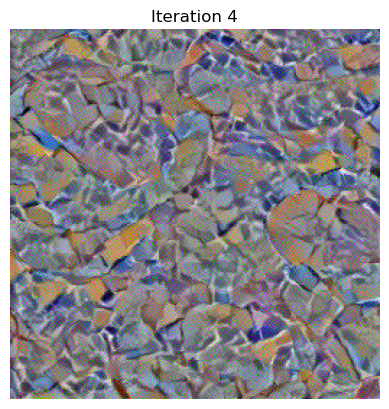

iteration 5
content_loss=162.46340942382812 style_loss=0.054843008518218994
content_loss=161.8260955810547 style_loss=0.053955357521772385
content_loss=160.55697631835938 style_loss=0.05382733419537544
content_loss=159.4005126953125 style_loss=0.05335070565342903
content_loss=158.51536560058594 style_loss=0.052577294409275055
content_loss=157.2537841796875 style_loss=0.05234348773956299
content_loss=156.38287353515625 style_loss=0.05186370760202408
content_loss=155.6527099609375 style_loss=0.05151062086224556
content_loss=154.5478973388672 style_loss=0.05128995701670647
content_loss=153.9503936767578 style_loss=0.05060611292719841
content_loss=152.12303161621094 style_loss=0.05128433555364609
content_loss=152.11566162109375 style_loss=0.049799855798482895
content_loss=150.84231567382812 style_loss=0.049922507256269455
content_loss=149.74673461914062 style_loss=0.04973609000444412
content_loss=149.15147399902344 style_loss=0.04908832162618637
content_loss=148.3309783935547 style_loss=0.

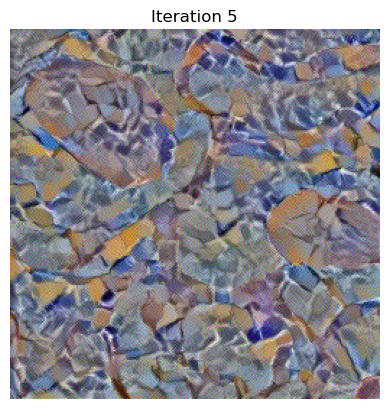

iteration 6
content_loss=144.17718505859375 style_loss=0.04788173735141754
content_loss=144.14718627929688 style_loss=0.04690108448266983
content_loss=143.20953369140625 style_loss=0.04700533673167229
content_loss=141.9378662109375 style_loss=0.04713546857237816
content_loss=141.85357666015625 style_loss=0.04623124748468399
content_loss=141.3792724609375 style_loss=0.04602872580289841
content_loss=140.43057250976562 style_loss=0.04607921838760376
content_loss=139.9752960205078 style_loss=0.045602403581142426
content_loss=139.25186157226562 style_loss=0.045328546315431595
content_loss=138.3197479248047 style_loss=0.0452670156955719
content_loss=137.75645446777344 style_loss=0.0448550283908844
content_loss=137.24534606933594 style_loss=0.04457973316311836
content_loss=136.0601806640625 style_loss=0.04474799707531929
content_loss=136.00384521484375 style_loss=0.04391462355852127
content_loss=134.82977294921875 style_loss=0.044322945177555084
content_loss=134.21575927734375 style_loss=0.04

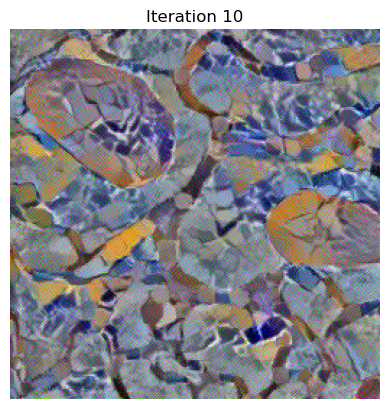

iteration 11
content_loss=100.64018249511719 style_loss=0.03247179463505745
content_loss=100.28951263427734 style_loss=0.03253970295190811
content_loss=100.15631103515625 style_loss=0.03235664591193199
content_loss=99.77902221679688 style_loss=0.03242542967200279
content_loss=99.64533996582031 style_loss=0.03224840760231018
content_loss=99.32157897949219 style_loss=0.03226988762617111
content_loss=99.19084167480469 style_loss=0.032097138464450836
content_loss=98.89657592773438 style_loss=0.03210312873125076
content_loss=98.68572998046875 style_loss=0.03202588111162186
content_loss=98.43630981445312 style_loss=0.031976114958524704
content_loss=98.24293518066406 style_loss=0.031861864030361176
content_loss=97.94007873535156 style_loss=0.03187703713774681
content_loss=97.8919448852539 style_loss=0.03164612129330635
content_loss=97.30742645263672 style_loss=0.0320291742682457
content_loss=97.42705535888672 style_loss=0.031622398644685745
content_loss=97.27986145019531 style_loss=0.03154373

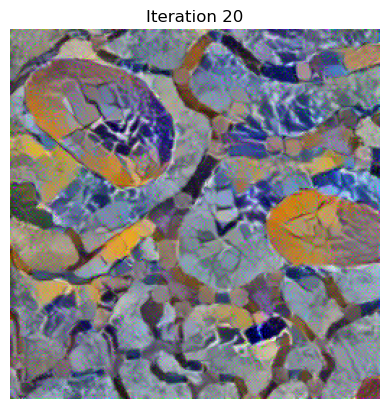

iteration 21
content_loss=77.96573638916016 style_loss=0.025833386927843094
content_loss=77.94091033935547 style_loss=0.025793056935071945
content_loss=77.8702621459961 style_loss=0.02580101415514946
content_loss=77.83395385742188 style_loss=0.02577315643429756
content_loss=77.76778411865234 style_loss=0.025777917355298996
content_loss=77.74231719970703 style_loss=0.02574354037642479
content_loss=77.67257690429688 style_loss=0.025752389803528786
content_loss=77.64291381835938 style_loss=0.02572176419198513
content_loss=77.56844329833984 style_loss=0.025736570358276367
content_loss=77.53121948242188 style_loss=0.025714412331581116
content_loss=77.4736328125 style_loss=0.025712881237268448
content_loss=77.44387817382812 style_loss=0.025682782754302025
content_loss=77.36619567871094 style_loss=0.025702601298689842
content_loss=77.36115264892578 style_loss=0.025648394599556923
content_loss=77.27532958984375 style_loss=0.025677567347884178
content_loss=77.2632064819336 style_loss=0.02563117

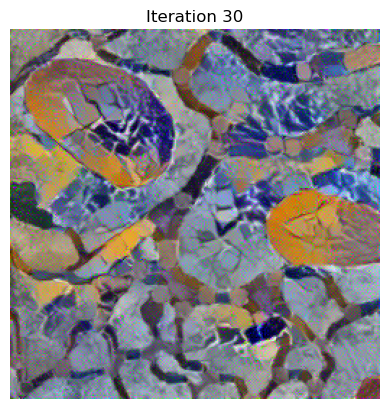

iteration 31
content_loss=71.70138549804688 style_loss=0.024146702140569687
content_loss=71.68569946289062 style_loss=0.024137718603014946
content_loss=71.66394805908203 style_loss=0.02413458749651909
content_loss=71.64141845703125 style_loss=0.024131815880537033
content_loss=71.62821960449219 style_loss=0.024119075387716293
content_loss=71.60006713867188 style_loss=0.024121854454278946
content_loss=71.59785461425781 style_loss=0.024099145084619522
content_loss=71.5682373046875 style_loss=0.02410374954342842
content_loss=71.55875396728516 style_loss=0.024088360369205475
content_loss=71.52159881591797 style_loss=0.024101480841636658
content_loss=71.5185546875 style_loss=0.02407972142100334
content_loss=71.48780822753906 style_loss=0.024085843935608864


In [11]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

style_transfer(
    image=image_in,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e3,
)

... and using the content image as a starting point.

In [ ]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

style_transfer(
    image=content,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e5,
)

# Neural Style Transfer

We'll perform style transfer between images.

## Select Content Image

We begin by loading the example image titled `neuraltissue_with_colorlabels.png`, of which we crop a patch of 256 by 256 pixels.

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [ ]:
from PIL import Image

content = (
    Image.open("neuraltissue_with_colorlabels.png")
    .convert("RGB")
    .crop((100, 170, 100 + 256, 170 + 256))
)

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(content)
plt.axis("off")
plt.show()


## Select Style Image

We use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona) in the image `lizard.png`.

In [ ]:
style = Image.open("lizard.png").convert("RGB").resize((256, 256))

In [ ]:
plt.imshow(style)
plt.axis("off")
plt.show()

## Load Pretrained Neural Network

We import the VGG16 model, a pretrained neural network known for its proficiency in image recognition tasks, with weights initialized from the ImageNet dataset. We then set the model to evaluation mode and freeze all weights to prevent further changes during our operations.

In [ ]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.eval()
model.requires_grad_(False)

print(model)

## Implement Style Transfer

We'll define a function that minimize the style and content losses with respect to the reference images. 

We define a function for calculating the Gram matrix between all the activations of a specific layer.
The Gram matrix represents the correlations between different feature maps (or channels) of the output of a convolutional layer.

This is the `gram()` function and add it to `fnc_style_transfer.py`:
```python
def gram(tensor):
    from torch import bmm
    
    batch_size, num_channels, height, width = tensor.size()
    activations = tensor.view(batch_size, num_channels, height * width)
    gram = bmm(activations, activations.transpose(1, 2)) / (height * width)

    return gram
```
This function:
- Unpacks the dimensions of the input tensor
- Reshapes the tensor so it's a 2D matrix, with channels as activations and height*width as observations
- Computes the Gram matrix as the product of the matrix by its transpose, normalizing by the number of elements in each feature map (`height * width`)

We also add the `image_to_tensor()` function to `fnc_style_transfer.py` (the same function as for the DeepDream project).
```python
def image_to_tensor(im, mean, std):
    import torchvision.transforms as tt

    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])

    return normalize(im).unsqueeze(0).requires_grad_(True)
```

We also add the `tensor_to_image()` function to `fnc_style_transfer.py` (the same function as for the DeepDream project).
```python
def tensor_to_image(image, mean, std):
    import torchvision.transforms as tt
    import numpy as np
    from PIL import Image

    denormalize = tt.Normalize(mean=-mean / std, std=1 / std)

    im_array = denormalize(image.data.clone().detach().squeeze()).numpy()
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(im_array, "RGB")
```

We also add the `Fwd_Hooks()` function to `fnc_style_transfer.py` (the same function as for the DeepDream project).

```python
class Fwd_Hooks():
    def __init__(self, layers):
        self.hooks = []
        self.activations_list = []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))

    def hook_func(self, layer, input, output):
        self.activations_list.append(output)

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        for hook in self.hooks:
            hook.remove()
```

We finally implement the `style_transfer()` function.

The `style_transfer()` function performs style transfer on images using neural networks, a technique where an image is created from the style of one image (e.g., an image of the texture of Gaudi's lizard) and the content of another (e.g., an image of neural tissue). The function accepts an image, content, and style inputs, along with parameters defining layers in a neural network model, learning rate (`lr`), a regularization parameter (`beta`), and the number of iterations. It normalizes the input images and converts them into tensors. The function then extracts activations from the specified content and style layers using a model and computes Gram matrices for style representations. An optimizer is set up to minimize a loss function, which is a combination of content loss (how much the transformed image deviates from the content in the content image) and style loss (how different the style of the transformed image is from the style image), with the style loss being scaled by `beta`. During optimization, the function iteratively updates the image to minimize the total loss, displaying the intermediate results at specified intervals. The final transformed image is returned at the end of the function.

In [ ]:
def style_transfer(image, content, style, content_layers, style_layers, 
                   lr=1, iter_num=100, beta=1e3):
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    from fnc_style_transfer import (image_to_tensor, tensor_to_image, Fwd_Hooks, 
                                    gram)

    # Normalization parameters typically used with pretrained models
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    # input image
    image_tensor = image_to_tensor(image, mean, std)  # .requires_grad_(True)

    # content
    with Fwd_Hooks(content_layers) as fh:
        _ = model(image_to_tensor(content, mean, std))
    content_activations = [activations.detach() 
                           for activations in fh.activations_list]

    # style
    with Fwd_Hooks(style_layers) as fh:
        _ = model(image_to_tensor(style, mean, std))
    gram_targets = [gram(activations.detach()) 
                    for activations in fh.activations_list]

    optimizer = torch.optim.LBFGS([image_tensor], lr=lr)
    mse_loss = torch.nn.MSELoss(reduction="sum")

    def closure():
        optimizer.zero_grad()

        # content
        with Fwd_Hooks(content_layers) as fh:
            _ = model(image_tensor)
        image_content_activations = fh.activations_list

        content_loss = 0
        for ia, ca in zip(image_content_activations, content_activations):
            n_f = ia.shape[1]
            content_loss += mse_loss(ia, ca) / n_f**2
        content_loss /= len(image_content_activations)

        # style
        with Fwd_Hooks(style_layers) as fh:
            _ = model(image_tensor)
        gram_image = [gram(activations) for activations in fh.activations_list]

        style_loss = 0
        for gi, gt in zip(gram_image, gram_targets):
            n_g = gi.shape[1]
            style_loss += mse_loss(gi, gt) / n_g**2
        style_loss /= len(gram_image)

        print(f"content_loss={content_loss} style_loss={style_loss}")

        total_loss = content_loss + beta * style_loss
        total_loss.backward()
        return total_loss

    for i in range(iter_num):
        print(f"iteration {i}")

        optimizer.step(closure)

        image = tensor_to_image(image_tensor, mean, std)

        if i <= 5 or i % 10 == 0 or i == iter_num - 1:
            plt.imshow(image)
            plt.title(f"Iteration {i}")
            plt.axis("off")
            plt.show()

    return image

## Apply Style Transform

We start by writing a `plot_style_transform()` function to plot side-by-side content image, style image, and trnasformed image.

In [ ]:
def plot_style_transform(content, style, image):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(content)
    plt.title("Content image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(style)
    plt.title("Style image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title("Output image")
    plt.axis("off")

    plt.show()

We first apply it with a random image as starting point.

In [ ]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

image_out = style_transfer(
    image=image_in,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e3,
)

plot_style_transform(content, style, image_out)

We then apply it using the content image as a starting point. Since in this case the input already has the content information, we can increase the value of the regularization parameter to `beta=1e5` and give more weight to the style loss. We also need less iterations to get to a reasonable results.

In [ ]:
image_out = style_transfer(
    image=content,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e5,
)

plot_style_transform(content, style, image_out)